# Preamble

In [1]:
# Load packages and libraries

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import numpy as np
import uuid
import folium
from folium.plugins import MarkerCluster
import janitor # !pip install git+https://github.com/pyjanitor-devs/pyjanitor.git
    # import importlib
    # importlib.reload(janitor)
projectfolder = "/Users/upar/Library/CloudStorage/OneDrive-UniversidaddelosAndes/03 MONEY/CESED/ANDI/"
data_dir = "/Users/upar/Library/CloudStorage/OneDrive-UniversidaddelosAndes/03 MONEY/CESED/ANDI/Datos"

os.listdir(projectfolder)


['.Rhistory',
 'Datos',
 '.DS_Store',
 'Output',
 'Scripts',
 '.backups',
 'ANDI.Rproj',
 '.Rproj.user']

/opt/anaconda3/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.drop` instead.
  return method(self._obj, *args, **kwargs)


(43331, 7)

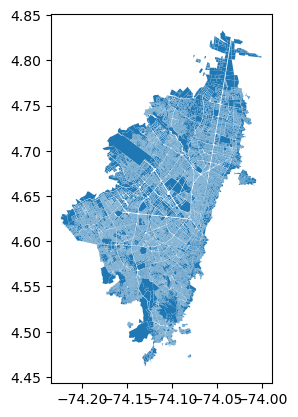

In [3]:
manz_MGN = gpd.read_file(f"{projectfolder}/Datos/1-InputData/GIS/MGN2018_URB_MANZANA/MGN_URB_MANZANA.shp")
manz_MGN=manz_MGN[manz_MGN['DPTO_CCDGO']=='11']
manz_MGN=manz_MGN[manz_MGN['CPOB_CCDGO']=='11001000']
manz_MGN=manz_MGN.clean_names().copy()
manz_MGN=manz_MGN.remove_columns(['cpob_ccdgo', 'dpto_ccdgo', 'mpio_ccdgo', 'clas_ccdgo','cpob_ccdgo']).copy()
manz_MGN.plot()
manz_MGN.shape

# Aggregating census data to *manzanas*

In [4]:
# Import census data
personas = pd.read_csv(f"{data_dir}/1-InputData/Censo DANE 2018/11_Bogota_CSV/CNPV2018_5PER_A2_11.CSV")
personas=personas.remove_columns(['U_MPIO', 'U_DPTO']).clean_names().copy()
personas['id']=[str(uuid.uuid4()) for _ in range(len(personas))]
mgn = pd.read_csv(f"{data_dir}/1-InputData/Censo DANE 2018/11_Bogota_CSV/CNPV2018_MGN_A2_11.CSV")
mgn = mgn.drop(columns=['U_MPIO', 'U_DPTO']).clean_names().copy()

/opt/anaconda3/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.drop` instead.
  return method(self._obj, *args, **kwargs)


In [5]:
#-------------------------------------------------------------------------
# Create categorical variables
#-------------------------------------------------------------------------
# Dummy variable for ethnicity
personas=personas.case_when(
    (personas.pa1_grp_etnic<=5), 1,
    (personas.pa1_grp_etnic==6), 0,
    (personas.pa1_grp_etnic==9), np.nan,
    "error",
    column_name="alguna_etnia"
).copy()

# Dummy variable if born outside of Bogota
personas=personas.case_when(
    (personas.pa_lug_nac==1), 1,
    (personas.pa_lug_nac==9), np.nan,
    0,
    column_name="foraneo"
).copy()

/opt/anaconda3/lib/python3.9/site-packages/pandas_flavor/register.py:157: DeprecationWarning: The last argument in the variable arguments has been assigned as the default. Note however that this will be deprecated in a future release; use an even number of boolean conditions and values, and pass the default argument to the `default` parameter instead.
  return method(self._obj, *args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/pandas_flavor/register.py:157: DeprecationWarning: The last argument in the variable arguments has been assigned as the default. Note however that this will be deprecated in a future release; use an even number of boolean conditions and values, and pass the default argument to the `default` parameter instead.
  return method(self._obj, *args, **kwargs)


In [6]:
#-------------------------------------------------------------------------
# Clean variables for further manzana aggregation
#-------------------------------------------------------------------------
personas['p_nivel_anosr'].replace(99, np.nan,inplace=True)




In [7]:
# Merge all census dataframes
merge=pd.merge(personas, mgn, on="cod_encuestas", suffixes=['_per', '_mgn'], how="inner")
merge

tipo_reg  ua_clase_per  cod_encuestas  u_vivienda_per  p_nrohog  \
0               5             1          60400               1       1.0   
1               5             1          60400               1       1.0   
2               5             1          60400               1       1.0   
3               5             1          60400               1       1.0   
4               5             1          60404               1       1.0   
...           ...           ...            ...             ...       ...   
7181464         5             3      902428795               1       1.0   
7181465         5             3      902428795               1       1.0   
7181466         5             3      902428795               1       1.0   
7181467         5             3      902428795               1       1.0   
7181468         5             3      902428795               1       1.0   

         p_nro_per  p_sexo  p_edadr  p_parentescor  pa1_grp_etnic  ...  \
0                1       1        3            3.0              6  ...   
1                2       2       10            2.0              6  ...   
2                3       2        5            3.0              6  ...   
3                4       1       11            1.0              6  ...   
4                1       2       12            3.0              6  ...   
...            ...     ...      ...            ...            ...  ...   
7181464          3       1        5            3.0              1  ...   
7181465          4       1        4            3.0              1  ...   
7181466          5       2        4            3.0              1  ...   
7181467          6       1        3            3.0              1  ...   
7181468          7       1        6            3.0              1  ...   

         ua1_localidad  u_sect_rur  u_secc_rur  ua2_cpob  u_sect_urb  \
0                   13           0           0         0        5111   
1                   13           0           0         0        5111   
2                   13           0           0         0        5111   
3                   13           0           0         0        5111   
4                   13           0           0         0        5111   
...                ...         ...         ...       ...         ...   
7181464             99           2          26         0           0   
7181465             99           2          26         0           0   
7181466             99           2          26         0           0   
7181467             99           2          26         0           0   
7181468             99           2          26         0           0   

         u_secc_urb  u_mza  u_edifica  u_vivienda_mgn            cod_dane_anm  
0                 3      9          4               1  1100110000000051110309  
1                 3      9          4               1  1100110000000051110309  
2                 3      9          4               1  1100110000000051110309  
3                 3      9          4               1  1100110000000051110309  
4                 1     11          8               1  1100110000000051110111  
...             ...    ...        ...             ...                     ...  
7181464           0      0          2               1  1100130022600000000000  
7181465           0      0          2               1  1100130022600000000000  
7181466           0      0          2               1  1100130022600000000000  
7181467           0      0          2               1  1100130022600000000000  
7181468           0      0          2               1  1100130022600000000000  

[7181469 rows x 60 columns]

In [8]:
# Check that during the merge we didn't lose information:
pd.merge(pd.Series(personas.isna().mean(), name='personas'), 
         pd.Series(merge.isna().mean(), name='merge'),
         left_index=True,
         right_index=True,
         how='outer')

personas     merge
alguna_etnia      0.019852  0.019852
cod_dane_anm           NaN  0.000000
cod_encuestas     0.000000  0.000000
condicion_fisica  0.004446  0.004446
foraneo           0.018613  0.018613
...                    ...       ...
ua1_localidad          NaN  0.000000
ua2_cpob               NaN  0.000000
ua_clase          0.000000       NaN
ua_clase_mgn           NaN  0.000000
ua_clase_per           NaN  0.000000

[62 rows x 2 columns]

In [9]:
# Check that all people merged
print(merge.shape[0])
personas.shape[0]==merge.shape[0]

7181469


True

## Population by manzana
I need to count the number of people in each manzana. 

In [13]:
manz_MGN.columns,manz_MGN.shape

(43331, 11)

In [10]:
merge.columns

Index(['tipo_reg', 'ua_clase_per', 'cod_encuestas', 'u_vivienda_per',
       'p_nrohog', 'p_nro_per', 'p_sexo', 'p_edadr', 'p_parentescor',
       'pa1_grp_etnic', 'pa11_cod_etnia', 'pa12_clan', 'pa21_cod_vitsa',
       'pa22_cod_kumpa', 'pa_habla_leng', 'pa1_entiende', 'pb_otras_leng',
       'pb1_qotras_leng', 'pa_lug_nac', 'pa_vivia_5anos', 'pa_vivia_1ano',
       'p_enfermo', 'p_quehizo_ppal', 'pa_lo_atendieron', 'pa1_calidad_serv',
       'condicion_fisica', 'p_alfabeta', 'pa_asistencia', 'p_nivel_anosr',
       'p_trabajo', 'p_est_civil', 'pa_hnv', 'pa1_thnv', 'pa2_hnvh',
       'pa3_hnvm', 'pa_hnvs', 'pa1_thsv', 'pa2_hsvh', 'pa3_hsvm', 'pa_hfc',
       'pa1_thfc', 'pa2_hfch', 'pa3_hfcm', 'pa_uhnv', 'pa1_mes_uhnv',
       'pa2_ano_uhnv', 'id', 'alguna_etnia', 'foraneo', 'ua_clase_mgn',
       'ua1_localidad', 'u_sect_rur', 'u_secc_rur', 'ua2_cpob', 'u_sect_urb',
       'u_secc_urb', 'u_mza', 'u_edifica', 'u_vivienda_mgn', 'cod_dane_anm'],
      dtype='object')

In [62]:
# Grouping person dataframe by manzana level
censo_manzanas=merge.groupby('cod_dane_anm').agg({
    'id': 'count',
    'p_nivel_anosr':['mean', 'std'],
    'alguna_etnia':'mean',
    'foraneo':'mean'
})

In [63]:
censo_manzanas.head()

id p_nivel_anosr           alguna_etnia   foraneo
                        count          mean       std         mean      mean
cod_dane_anm                                                                
1100110000000000000000  31807      4.023800  2.370984     0.045608  0.458913
1100110000000011010101     13      3.833333  2.228602     0.000000  0.833333
1100110000000011010102    442      4.048662  2.135088     0.002283  0.744292
1100110000000011010103    787      5.069065  2.504372     0.022049  0.710765
1100110000000011010104   2511      5.424798  2.434432     0.033400  0.675784

In [64]:
# Change columns to single index instead of multi index
censo_manzanas.columns=list(map("_".join, censo_manzanas.columns.values))
censo_manzanas

id_count  p_nivel_anosr_mean  p_nivel_anosr_std  \
cod_dane_anm                                                              
1100110000000000000000     31807            4.023800           2.370984   
1100110000000011010101        13            3.833333           2.228602   
1100110000000011010102       442            4.048662           2.135088   
1100110000000011010103       787            5.069065           2.504372   
1100110000000011010104      2511            5.424798           2.434432   
...                          ...                 ...                ...   
1100130102000000000000        19            4.428571           2.593313   
1100130110100000000000        56            3.803922           2.010170   
1100130110900000000000        45            3.487179           2.011438   
1100130111000000000000       108            3.650000           2.451036   
1100130113500000000000        18            4.705882           2.494111   

                        alguna_etnia_mean  foraneo_mean  
cod_dane_anm                                             
1100110000000000000000           0.045608      0.458913  
1100110000000011010101           0.000000      0.833333  
1100110000000011010102           0.002283      0.744292  
1100110000000011010103           0.022049      0.710765  
1100110000000011010104           0.033400      0.675784  
...                                   ...           ...  
1100130102000000000000           0.000000      0.611111  
1100130110100000000000           0.036364      0.679245  
1100130110900000000000           0.000000      0.613636  
1100130111000000000000           0.000000      0.759259  
1100130113500000000000           0.000000      0.666667  

[38567 rows x 5 columns]

In [66]:
# Join manzana data to spatial data
M=pd.merge(manz_MGN, censo_manzanas, left_on='manz_ccnct', right_index=True, how='right')
M.columns

Index(['cod_secc', 'manz_ccnct', 'cod_ag', 'shape_leng', 'shape_area',
       'cod_rdtm', 'geometry', 'id_count', 'p_nivel_anosr_mean',
       'p_nivel_anosr_std', 'alguna_etnia_mean', 'foraneo_mean'],
      dtype='object')

<Axes: >

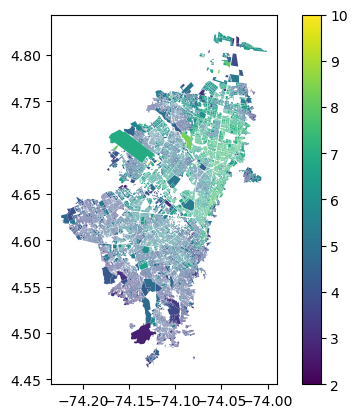

In [75]:
M.plot(column="p_nivel_anosr_mean", legend=True)

In [76]:
M.head()

cod_secc              manz_ccnct  cod_ag  shape_leng  \
NaN                        NaN  1100110000000000000000     NaN         NaN   
501055.0  11001100000000110101  1100110000000011010101  162540    0.004176   
501056.0  11001100000000110101  1100110000000011010102  162648    0.005631   
501057.0  11001100000000110101  1100110000000011010103  163041    0.011082   
501058.0  11001100000000110101  1100110000000011010104  162961    0.008378   

            shape_area                  cod_rdtm  \
NaN                NaN                       NaN   
501055.0  6.972580e-07  110011040000000011010101   
501056.0  1.441212e-06  110011040000000011010102   
501057.0  4.559625e-06  110011040000000011010103   
501058.0  2.816704e-06  110011040000000011010104   

                                                   geometry  id_count  \
NaN                                                    None     31807   
501055.0  POLYGON ((-74.08189 4.58460, -74.08189 4.58460...        13   
501056.0  POLYGON ((-74.08092 4.58565, -74.08089 4.58561...       442   
501057.0  POLYGON ((-74.07966 4.58357, -74.07941 4.58317...       787   
501058.0  POLYGON ((-74.08211 4.58426, -74.08213 4.58422...      2511   

          p_nivel_anosr_mean  p_nivel_anosr_std  alguna_etnia_mean  \
NaN                 4.023800           2.370984           0.045608   
501055.0            3.833333           2.228602           0.000000   
501056.0            4.048662           2.135088           0.002283   
501057.0            5.069065           2.504372           0.022049   
501058.0            5.424798           2.434432           0.033400   

          foraneo_mean  
NaN           0.458913  
501055.0      0.833333  
501056.0      0.744292  
501057.0      0.710765  
501058.0      0.675784

# Add stratum information

Given the fact that the manzanas from the MGN 2018 + census geodataframe are not identical in shape or in quantity to those manzanas from ManzanaEstratificacion (those that include the *stratum information*), I cannot join them. Thus we will create two separate files for each of the two to use separately: the `M` that includes population (`id_count`) will be used for 2018 data, the ManzanaEstratificacion that *does not* have population data will be used for the other years and graphed with total crime number instead of crime **rates**.

<Axes: >

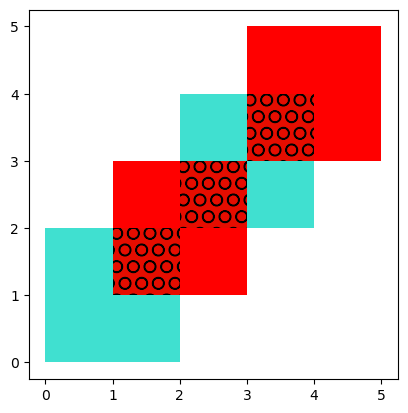

In [133]:
from shapely.geometry import Polygon
polys1 = gpd.GeoSeries([Polygon([(0,0), (2,0), (2,2), (0,2)]),
                              Polygon([(2,2), (4,2), (4,4), (2,4)])])
polys2 = gpd.GeoSeries([Polygon([(1,1), (3,1), (3,3), (1,3)]),
                              Polygon([(3,3), (5,3), (5,5), (3,5)])])
df1 = gpd.GeoDataFrame({'geometry': polys1, 'df1_data':[1,2]})
df2 = gpd.GeoDataFrame({'geometry': polys2, 'df2_data':[1,2]})
fig, ax = plt.subplots()
df1.plot(ax=ax, color='turquoise', label='df1')
df2.plot(ax=ax, color='red', label='df2')
gpd.overlay(df1, df2, how='intersection').plot(ax=ax, color='green',alpha=.1,hatch='O')

# Export data

In [166]:
M=M.rename(columns={'id_count':'pop_2018'}).copy()
M.to_file(f"{data_dir}/2-IntermediateData/GIS/manzana_censo2018_poblacion.gpkg", driver="GPKG")